In [5]:

import spacy
from spacy import displacy
import nltk
import torch
from supar import Parser
import math
from thinc.api import set_gpu_allocator, require_gpu
set_gpu_allocator("pytorch")
require_gpu(0)

True

In [1]:
import pandas as pd
from sklearn.utils import shuffle
class DataLoader():
    def __init__(self) :
        # dict for path and source
        self.FilePath = {
            'L2Writing':'data/L2writing/train.csv',
            'SHU':'data/SHU/spring.xlsx',
            'ASAP':'data/asap-aes/training_set_rel3.xls',
            'final':'data/Final-all/winter.csv'
        }
    def LoadData(self,source):
        self.source = source
        self.FileName = self.FilePath[self.source]
        if 'csv' in self.FileName:
            self.data = pd.read_csv(self.FileName)
        else:
            self.data = pd.read_excel(self.FileName)
    def GetData(self,source):
        '''
        source: one of 'L2Writing','SHU','ASAP','final'
        '''
        self.LoadData(source)
        return self.data
    def ShuffleData(self):
        self.shuffled = shuffle(self.data)
    def GetShuffled(self):
        self.ShuffleData()
        return self.shuffled

In [2]:
loader = DataLoader()
d = loader.GetData('final')

In [3]:
d[d['score'] == 5]

,用户ID,学号,姓名,班级,院系,任课教师,Class,Prompt,score,text
1219,1003248777,21122599,余大力,2021-22冬季通用英语C2戴朝晖1025期末,材料科学与工程学院,1002658410(戴朝晖),C,19121439,5.0,Everyone will have the feeling that want to ...
2041,1003248911,21122738,王馨毅,2021-22冬季通用英语D2陈荣1003期末,管理学院,1002658399(陈荣),D,19121435,5.0,"When people meet new friends,they always know ..."


In [ ]:
for t in d['text']:
    

In [4]:
d = d.loc[d['score'] > 0,:]

In [17]:
import numpy as np
import markov_clustering as mcl
f = np.load('features/final_winter_sent.npz')

In [30]:
sim = f[f.files[2087]]
raw = []
for row in sim:
    for col in row:
        if 0 < col < 1:
            raw.append(col)

In [31]:
np.fill_diagonal(sim,0)

In [32]:
sim_thres = sim.copy()
for i in range(len(sim_thres)):
    for j in range(len(sim_thres)):
        if sim_thres[i,j] <= np.percentile(raw,90):
            sim_thres[i,j] = 0

In [33]:
res = mcl.run_mcl(sim_thres,inflation=10)
clusters = mcl.get_clusters(res)

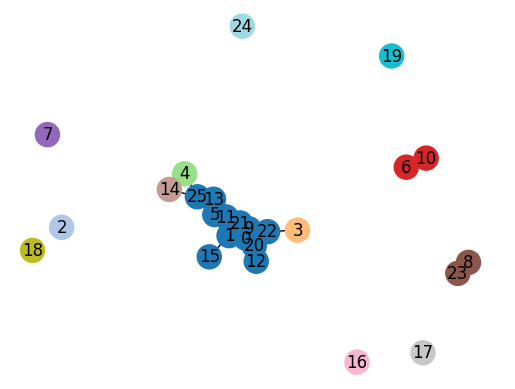

In [34]:
import matplotlib.pyplot as plt
import networkx as nx
mcl.draw_graph(sim_thres,clusters)

In [6]:
NLP = spacy.load('en_core_web_trf')
SuPar = Parser.load('crf-con-en')

In [3]:
#doc = NLP(d.iloc[0])
doc = NLP('I drank a cup of water that has some juice in it.')

In [9]:
s = [[token.text for token in sent if token.text] for sent in list(doc.sents)]

In [13]:
sent_trees = str(SuPar.predict(s[0],prob=True,verbose= False).sentences[0])
sent_trees

'(TOP (S (NP (_ I)) (VP (_ drank) (NP (NP (_ a) (_ cup)) (PP (_ of) (NP (_ water))) (SBAR (WHNP (_ that)) (S (VP (_ has) (NP (_ some) (_ juice)) (PP (_ in) (NP (_ it)))))))) (_ .)))'

In [14]:
a = nltk.Tree.fromstring(sent_trees)

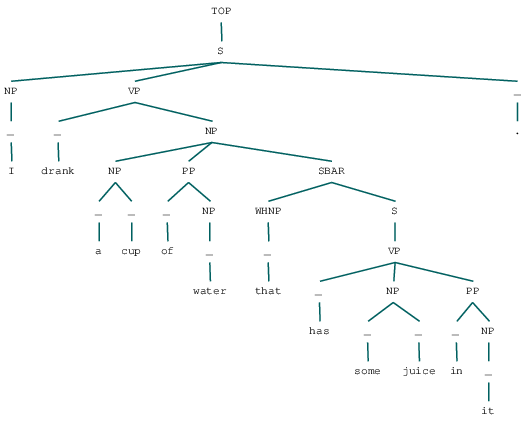

In [15]:
a

In [5]:
d[20]

'To begin with,talking to your friends about your problems may be agood idea.Friends are the same as us in many perspectives.As a result,they can considerate in our shoes and help us solve the trouble.More importantly,we should tell adults surround by about our homesickness.To some extent,they can offer us some tips to overcoming homesickness and give us love because they are the same age as our parents.As a consequence,they will show empassy to us and think in our way.Besides,reading some book about overcoming homesickness is also a fantastic way to deal with this problem.For examble,we can learn some physiological hints that can give us some belongings.Last but not least,I think the root to solve this problem is overcome our thoughts in our heart.We feel homesickness because of our feeling of alone.But if our hearts become hard,we can be immunity to homesickness. '

In [6]:
def CreateTree(token):
    if token.n_lefts == 0 and token.n_rights == 0:
        return nltk.Tree('_'.join([token.text,token.dep_]),[])
    else:    
        return nltk.Tree('_'.join([token.text,token.dep_]),[CreateTree(child) for child in token.children])

In [7]:
doc = NLP(d[20])

In [8]:
t = CreateTree(list(doc.sents)[0].root)

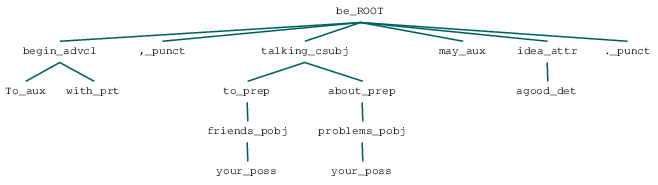

In [9]:
t

In [59]:
[t[i].label() for i in range(len(t))]

['begin_advcl', ',_punct', 'talking_csubj', 'may_aux', 'idea_attr', '._punct']

if labels of $n_1$ and $n_2$ are the same:
$$
C(n_1,n_2) = 1 + \sum_{J_1,J_2,|J_1| = |J_2|}\prod_{i=1}^{|J_1|}C(ch_{n1}[J_{1i}],ch_{n2}[J_{2i}])
$$
we are summing over all pairs of possible subsequences of children of all possible length (smaller than shorter tree length), allowing partial trees with gaps   
With decay factors :
$$
C(n_1,n_2) = \mu (\lambda^2 + \sum_{J_1,J_2,|J_1| = |J_2|} \lambda^{(d(J_1)+d(J_2))}\prod_{i=1}^{|J_1|}C(ch_{n1}[J_{1i}],ch_{n2}[J_{2i}]))
$$
where
$$
d(J_1) = J_{1l(J_1)} - J_{1i} + 1
$$
if they are different:
$$
C(n_1,n_2) = 0
$$
The tree kernel of $T_1$ and $T_2$ is:
$$
K(T_1,T_2) = \sum_{t_1\in N_{T_1}}\sum_{t_2\in N_{T_2}}C(t_1,t_2)
$$
with normalization
$$
K_{norm}(T_1,T_2) = \dfrac{K(T_1,T_2)}{\sqrt{K(T_1,T_1) \times K(T_2,T_2)}}
$$

In [89]:
import math
def GetAllComb(n,NumList):
    # Get all subsets of length n in the given list, and in the original order
    res = []
    if n == 1: # [0,1,2] --> [[0],[1],[2]]
        return [[i] for i in NumList]
    if n == len(NumList): # [0,1,2] --> [0,1,2]
        return [[i for i in NumList]]
    if n >= 2: # for each element before len(NumList)-n, insert that element into position 0 for all subsets of length n-1 of the remaining elements
        for start in range(len(NumList)-n+1): 
            # (3,[0,1,2,3,4])
            last = GetAllComb(n-1,NumList[start+1:])
            # 0 + (2,[1,2,3,4]), 1 + (2,[2,3,4]), 2 + (2,[3,4])
            for comb in last:
                comb.insert(0,NumList[start])
            res += last
        return res
def KernelFunction(tree1,tree2,t1index,t2index,prev,tree1Index,tree2Index):
    # If already calculated, return result directly
    #print(t1index,t2index)
    if prev[t1index][t2index] != -1:
        return prev[t1index][t2index]
    # tree1 and tree2 are actually trees of token objects
    # get dep labels of all nodes, t1 and t2 are trees of dep labels
    t1 = (tree1[0].dep_,[i.dep_ for i in tree1[1] if i])
    t2 = (tree2[0].dep_,[i.dep_ for i in tree2[1] if i])
    # mu and lambda are decay factors, mu penalize tree height and lambda penalize tree length
    mu =0.9
    lambda_ = 0.9
    k = 0 # final sum
    if t1[0] == t2[0]: # if labels are the same
        max_tree_len = min(len(t1[1]),len(t2[1]))
        for tree_len in range(1,max_tree_len+1) :
            # length of all possible subtrees 
            #ChildSeqs = GetAllComb(tree_len,[c for c in range(min(len(t1[1]),len(t2[1])))])
            if max_tree_len <= 10:
                ChildSeqs = comb_dict[max_tree_len][tree_len]
            else:
                ChildSeqs = GetAllComb(tree_len,[c for c in range(max_tree_len)])
            #print(ChildSeqs)
            # list of indices of all possible child sequences of given length
            for j1 in ChildSeqs:
                for j2 in ChildSeqs:
                    # Get all pairs of sub sequences
                    #print(j1,j2)
                    prod = 1 # product
                    #print(len(j1),tree_len)
                    for i in range(tree_len):
                        childt1 = tree1[1][j1[i]] # token object
                        childt2 = tree2[1][j2[i]]
                        prodt1 = (childt1,[j for j in childt1.children if j.text.isalpha()]) # build subtree 
                        prodt2 = (childt2,[j for j in childt2.children if j.text.isalpha()])
                        #if prodt1[1] and prodt2[1]:
                        #print(prodt1,prodt2)
                        t1index = tree1Index[childt1]
                        t2index = tree2Index[childt2]
                        res = KernelFunction(prodt1,prodt2,t1index,t2index,prev,tree1Index,tree2Index) 
                        prod = prod * res
                        #if prev[t1index][t2index]  == -1:
                        prev[t1index][t2index] = res
                        #print(prod)
                        # continue matching subtree
                    # finish matching indices j1 and j2, sum 
                    dt1 = j1[-1] - j1[0] + 1
                    dt2 = j2[-1] - j2[0] + 1    
                    k += ((lambda_) ** (dt1 + dt2)) * prod
        return mu * (lambda_**2 + k)
    else:
        return 0
def PartialTreeKernel(tree1,tree2):
    prev = [[-1 for i in range(len(tree2))] for j in range(len(tree1))]
    tree1Index = {list(tree1)[i]:i for i in range(len(tree1))}
    tree2Index = {list(tree2)[i]:i for i in range(len(tree2))}
    sim = 0
    for tokent1 in tree1:
        prodt1 = (tokent1,[i for i in tokent1.children if i.text.isalpha()])
        for tokent2 in tree2:
            # sum over all nodes
            prodt2 = (tokent2,[i for i in tokent2.children if i.text.isalpha()])
            if tokent1.text.isalpha() and (tokent1.dep_ == tokent2.dep_):
                #print('subtree',prodt1,prodt2)
                t1index = tree1Index[tokent1]
                t2index = tree2Index[tokent2]
                res = KernelFunction(prodt1,prodt2,t1index,t2index,prev,tree1Index,tree2Index)
                sim += res
                prev[t1index][t2index] = res
    return sim 
def normPTK(tree1,tree2):
    return PartialTreeKernel(tree1,tree2)/math.sqrt(PartialTreeKernel(tree1,tree1)*PartialTreeKernel(tree2,tree2))

In [106]:
comb_dict = {i:{j+1:[]for j in range(i)}  for i in range(1,10)}
for i in range(1,10):
    for j in range(i):
        comb_dict[i][j+1] = GetAllComb(j+1,[c for c in range(i)])
comb_dict

{1: {1: [[0]]},
 2: {1: [[0], [1]], 2: [[0, 1]]},
 3: {1: [[0], [1], [2]], 2: [[0, 1], [0, 2], [1, 2]], 3: [[0, 1, 2]]},
 4: {1: [[0], [1], [2], [3]],
  2: [[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]],
  3: [[0, 1, 2], [0, 1, 3], [0, 2, 3], [1, 2, 3]],
  4: [[0, 1, 2, 3]]},
 5: {1: [[0], [1], [2], [3], [4]],
  2: [[0, 1],
   [0, 2],
   [0, 3],
   [0, 4],
   [1, 2],
   [1, 3],
   [1, 4],
   [2, 3],
   [2, 4],
   [3, 4]],
  3: [[0, 1, 2],
   [0, 1, 3],
   [0, 1, 4],
   [0, 2, 3],
   [0, 2, 4],
   [0, 3, 4],
   [1, 2, 3],
   [1, 2, 4],
   [1, 3, 4],
   [2, 3, 4]],
  4: [[0, 1, 2, 3], [0, 1, 2, 4], [0, 1, 3, 4], [0, 2, 3, 4], [1, 2, 3, 4]],
  5: [[0, 1, 2, 3, 4]]},
 6: {1: [[0], [1], [2], [3], [4], [5]],
  2: [[0, 1],
   [0, 2],
   [0, 3],
   [0, 4],
   [0, 5],
   [1, 2],
   [1, 3],
   [1, 4],
   [1, 5],
   [2, 3],
   [2, 4],
   [2, 5],
   [3, 4],
   [3, 5],
   [4, 5]],
  3: [[0, 1, 2],
   [0, 1, 3],
   [0, 1, 4],
   [0, 1, 5],
   [0, 2, 3],
   [0, 2, 4],
   [0, 2, 5],
   [0, 3, 4],
  

In [ ]:
{list(sents[0])[i]:i for i in range(len(sents[0]))}

In [91]:
PartialTreeKernel(sents[10],sents[10])

29688.954416699304

In [103]:
doc =NLP(d['text'][485])
sents = list([i for i in doc.sents if len(str(i).strip()) > 5])

In [104]:
import numpy as np
sim_matrix= np.eye(len(sents),len(sents))
self_sim = []
trps = []
for i in range(len(sents)):
    self_sim.append(PartialTreeKernel(sents[i],sents[i]))
    #print(i)
print(self_sim)
for i in range(len(sents)):
    for j in range(i+1,len(sents)):
        
        sim_matrix[i,j] = PartialTreeKernel(sents[i],sents[j])/math.sqrt(self_sim[i]*self_sim[j])
        print(i,j,sim_matrix[i,j])
        trps.append((sents[i],sents[j],sim_matrix[i,j]))
sorted(trps,key=lambda x:x[2],reverse=True)

[257.8285372488546, 854.4090876281031, 425.485880850653, 423.3288484122328, 12.036103894829772, 1911.4105066948455, 60.52298267695608, 78.19052106497405, 674.3699534138082]
0 1 0.1214930380360927
0 2 0.05163098866662539
0 3 0.1209576118091131
0 4 0.18210987324815478
0 5 0.03709387312291799
0 6 0.057707312930135875
0 7 0.25194906404853507
0 8 0.07008291561372555
1 2 0.028690060138012227
1 3 0.08183565877227088
1 4 0.1359059426981164
1 5 0.02571696135884237
1 6 0.028852067991688962
1 7 0.15118361638166863
1 8 0.05077918439921417
2 3 0.03904148674724176
2 4 0.0713082909457364
2 5 0.03593466446338254
2 6 0.08508233105447262
2 7 0.08176568366224886
2 8 0.06744545085108947
3 4 0.20502711141814747
3 5 0.050174006220995666
3 6 0.10240903066125999
3 7 0.16173340317383592
3 8 0.07114595215438771
4 5 0.06948895814802172
4 6 0.08102996620289073
4 7 0.27228036783585496
4 8 0.11698863635414714
5 6 0.06297079979653433
5 7 0.052641308973474785
5 8 0.03537778594589577
6 7 0.0790337688344273
6 8 0.06036

[(What's more,making full use of IT tech.,
  The best way to overcoming homesickness is to cross the wickness hidden in the bottom of our heart.,
  0.27228036783585496),
 (  As a child born in Shanghai,I have never tasted the bitter and misery of homesickness until the epidemic this year.,
  The best way to overcoming homesickness is to cross the wickness hidden in the bottom of our heart.,
  0.25194906404853507),
 (First and foremost,asking you friends for mental help,you friends from other cities must have more experience about how to fight with these bad mood.,
  What's more,making full use of IT tech.,
  0.20502711141814747),
 (  As a child born in Shanghai,I have never tasted the bitter and misery of homesickness until the epidemic this year.,
  What's more,making full use of IT tech.,
  0.18210987324815478),
 (First and foremost,asking you friends for mental help,you friends from other cities must have more experience about how to fight with these bad mood.,
  The best way to ove

In [17]:
sents = list(doc.sents)
trps = []
for i in range(len(sents)):
    for j in range(i+1,len(sents)):
        doc1 = simnlp(str(sents[i]))
        doc2 = simnlp(str(sents[j]))
        trps.append((sents[i],sents[j],doc1.similarity(doc2)))
sorted(trps,key=lambda x:x[2],reverse=True)

NameError: name 'simnlp' is not defined

In [122]:
simnlp = spacy.load('en_core_web_sm')

In [219]:
doc1 = simnlp('I ate the orange that he gave me')
doc2 = simnlp('She refused the advice that he gave her')

In [11]:
normPTK(doc1,doc2)

0.9226337301976297

In [ ]:
doc1.similarity(doc2)

In [34]:
count = dict()
for i in range(len(d)):
    doc = NLP(d[i])
    for s in doc.sents:
        left = [i.dep_ for i in s.root.lefts if i.text.isalpha()]
        right = [i.dep_ for i in s.root.rights if i.text.isalpha()]
        vac = '_'.join(left) + '_V_' + '_'.join(right)
        if vac in count:
            count[vac][0] += 1
            count[vac][1].append(str(s))
        else:
            count[vac] = [1,[str(s)]]
    if i % 50 == 0:
        print(i)
len(count)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800


10026

In [76]:
vacs = []
others = []
for i in count.keys():
    cons = i.split('_')
    vindex = cons.index('V')
    left = cons[:vindex]
    right = cons[vindex+1:]
    if 'nsubj' in left or 'nsubjpass' in left and 'ccomp' in right:
        vacs.append((i,count[i]))
    elif 'nsubj' in left or 'nsubjpass' in left and 'attr' in right:
        vacs.append((i,count[i]))
    elif 'nsubj' in left or 'nsubjpass' in left and 'dobj' in right:
        vacs.append((i,count[i]))
    elif 'nsubj' in left or 'nsubjpass' in left and 'xcomp' in right:
        vacs.append((i,count[i]))
    elif 'nsubj' in left or 'nsubjpass' in left and right == ['prep']:
        vacs.append((i,count[i]))
    elif 'csubj' in left:
        vacs.append((i,count[i]))
    elif 'expl' in left :
        vacs.append((i,count[i]))
    else:
        others.append((i,count[i]))
others = sorted(others,key=lambda x:x[1][0],reverse=True)
for c in others[1:]:
    print(c[0],c[1][0])
    scount = 0
    for s in c[1][1]:
        print(s)
        scount += 1
        if scount >= 10:
            break

_V_ccomp 369
Let me tell you how to make new friends:
Remember that a good friendship should be made through the joint efforts.

That' s the main two ways I use in building up my English vocabulary,hope it will also helpful for someone.
Let me tell you soomething about it.
Wish you can make your friends'  parents like you!
Hope we can be better with our roommates.

These three methods are taken during my senior school' s learning and I find them quite sueful.
Wish you can deal with this problem smoothly.
Hope everyone have a strong and fit body.
Remember that being active and holding a positive attitude towards others are already half of the success.
_V_prep 268
Think about his action after anger faded.
 As for parents, things about children are always more important than other things.
Focus on the title and subtitles and topic sentences.
                                                                  Ways to Build Up Your English Vocabulary


  Thanks to my roomates.
Tips on improvi

+ subject + verb + clausal complement
  + nsubj_V_ccomp 
+ subject + verb + attribute
  + nsubj_V_attr
+ subject + verb + direct object
  + nsubj_V_dobj
+ subject + verb + open clausal complement
  + nsubj_V_xcomp
+ subject + verb + preposition
  + nsubj_V_prep
+ expletive + verb + attribute
  + expl_V_attr
+ clausal subject + verb + *
  + csubj_V

In [39]:
t = '''ROOT, acl, acomp, advcl, advmod, agent, amod, appos, attr, aux, auxpass, case, cc, ccomp, compound, conj, csubj, csubjpass, dative, dep, det, dobj, expl, intj, mark, meta, neg, nmod, npadvmod, nsubj, nsubjpass, nummod, oprd, parataxis, pcomp, pobj, poss, preconj, predet, prep, prt, punct, quantmod, relcl, xcomp'''
for s in t.split(','):
    print(s,spacy.explain(s.strip()))


ROOT root
 acl clausal modifier of noun (adjectival clause)
 acomp adjectival complement
 advcl adverbial clause modifier
 advmod adverbial modifier
 agent agent
 amod adjectival modifier
 appos appositional modifier
 attr attribute
 aux auxiliary
 auxpass auxiliary (passive)
 case case marking
 cc coordinating conjunction
 ccomp clausal complement
 compound compound
 conj conjunct
 csubj clausal subject
 csubjpass clausal subject (passive)
 dative dative
 dep unclassified dependent
 det determiner
 dobj direct object
 expl expletive
 intj interjection
 mark marker
 meta meta modifier
 neg negation modifier
 nmod modifier of nominal
 npadvmod noun phrase as adverbial modifier
 nsubj nominal subject
 nsubjpass nominal subject (passive)
 nummod numeric modifier
 oprd object predicate
 parataxis parataxis
 pcomp complement of preposition
 pobj object of preposition
 poss possession modifier
 preconj pre-correlative conjunction
 predet None
 prep prepositional modifier
 prt particle
 punct